In [1]:
"""
Plotting results of using HHL to solve the 2D Hele-Shaw flow.
"""

import os
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit.quantum_info import state_fidelity
import pickle

# Functions

In [2]:
def fidelity(qfunc, true):
    solution_qfun_normed = qfunc / np.linalg.norm(qfunc)
    solution_true_normed = true / np.linalg.norm(true)
    fidelity = state_fidelity(solution_qfun_normed, solution_true_normed)
    return fidelity

In [3]:
def HeleShaw(x, y, pin, pout, L, D, mu):
    """Analytical solution to the Hele-Shaw flow"""
    P = pin + ((pout-pin)*x/L)
    U = -(0.5/mu) * ( (pout-pin) * y * (D-y) / L)
    return P, U

In [4]:
def next_power_of_2(x):
    return 1 if x == 0 else 2**math.ceil(math.log2(x))

# Problem setup

In [5]:
nx = 2          # number of grid points in the x (horizontal) direction
ny = 3          # number of grid points in the y (vertical/span-wise) direction
nq = 3          # number of qubits required to represent the matrix (after transforming to pwer of 2 & Hermitian - see saved filename)
s = 50000       # number of shots used to run
var = 'pressure'   # which variable to solve for? pressure or velocity
savedir = f'models'
filename = f"{savedir}/2DHS_HHL_fulldata_{var}_nx{nx}_ny{ny}"
filename_metadata = f"_metadata"
filename_fulldata= f"_circ-fullresults_nqmatrix{nq}_backend-statevector_shots{s}"
saveFig      = False
figfilename  = f'Figs/2DHS_HHL_{var}_nx{nx}_ny{ny}.png'

# Load computed data

In [6]:
# parameters
file = open(f'{filename}{filename_metadata}.pkl', 'rb')
data = pickle.load(file)
file.close()
P_in    = data['P_in']
P_out   = data['P_out']
L       = data['L']
D       = data['D']
mu      = data['mu']
rho     = data['rho']

# solutions
file = open(f'{filename}{filename_fulldata}.pkl', 'rb')
data = pickle.load(file)
file.close()
state_true_norm    = data['classical_solution']
state_hhl          = data['counts_solution_vector']

In [7]:
# check if matrix was padded for non-2 power size
nsys = nx*ny
nsys_nxtpower = next_power_of_2(nsys)
if nsys_nxtpower-nsys > 0:
    state_hhl = state_hhl[:-(nsys_nxtpower-nsys)]
    state_true_norm = state_true_norm[:-(nsys_nxtpower-nsys)]
# check if matrix was Hermitian
if len(state_hhl) > nsys:
    state_hhl = state_hhl[-nsys:]
    state_true_norm = state_true_norm[-nsys:]

# Check results

In [8]:
# extract true states (for comparison)
print(f'True state:\t{state_true_norm}')
print(f'Sim state:\t{state_hhl}')

True state:	[0.57431815 0.04577332 0.57431815 0.04577332 0.57431815 0.04577332]
Sim state:	[0.57532599 0.04816638 0.57490869 0.0507937  0.57182165 0.04690416]


In [9]:
# compute fidelity
print(f'Fidelity: {fidelity(state_hhl, state_true_norm)}')

Fidelity: 0.9999600331038613


# Plotting

In [10]:
x = np.linspace(0, L, nx)
y = np.linspace(0, D, ny)

xx, yy = np.meshgrid(x, y)

# Analytic solution
P_analytic, U_analytic = HeleShaw(xx ,yy, P_in, P_out, L, L, mu)

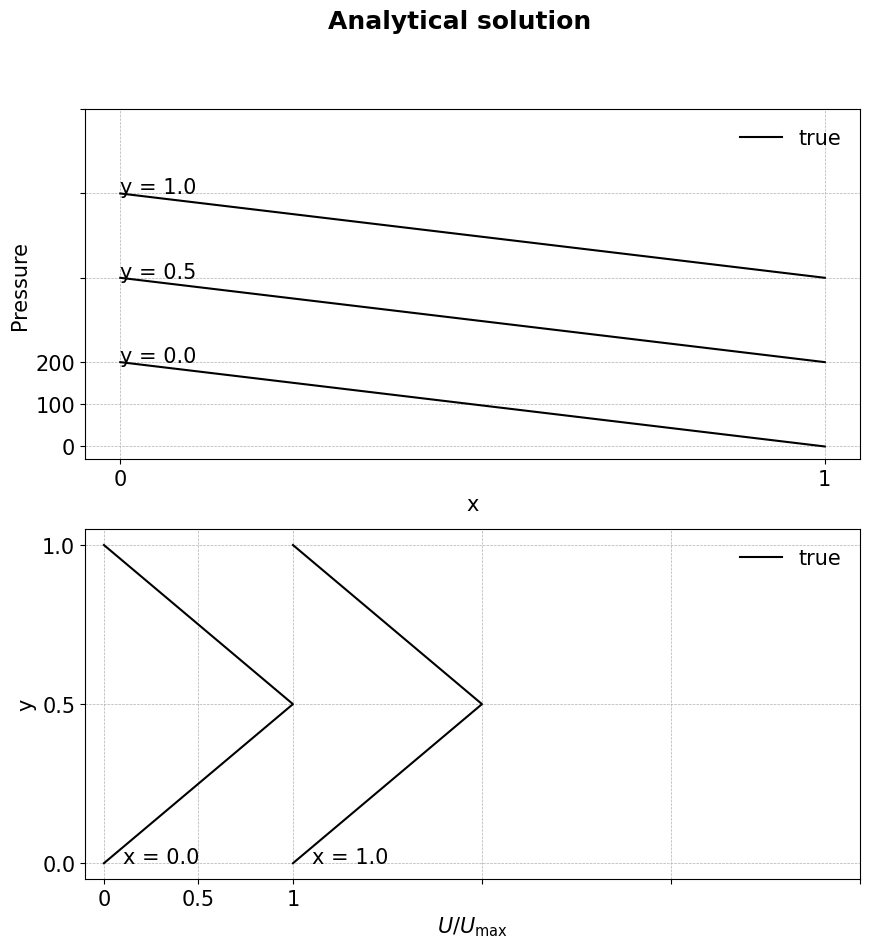

In [11]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2,1,figsize=(10,10), facecolor="1")
ax = ax.ravel()
fig.suptitle('Analytical solution', fontweight ="bold")

# Pressure
# first line (for legend)
i = 0
offset = i*P_in
prop = P_analytic[i,:] + offset
ax[0].plot(x, prop, 'k', label='true')
ax[0].text(x[0], prop[0], f'y = {y[i]:0.1f}')
# all other lines
for i in range(1, ny):
    offset = i*P_in
    prop = P_analytic[i,:] + offset
    ax[0].plot(x, prop, 'k')
    ax[0].text(x[0], prop[0], f'y = {y[i]:0.1f}')

ax[0].grid(linestyle = '--', linewidth = 0.5)
ax[0].set_yticks([0, 100, 200, 400, 600, 800])
ax[0].set_yticklabels(['0', '100', '200', '', '', ''])
ax[0].set_ylabel('Pressure')
ax[0].set_xticks(x)
ax[0].set_xlabel('x')
ax[0].legend(frameon=False);

# Velocity
Umax = np.max(U_analytic) # U_analytic[int(nx/2), int(ny/2)]  # Umax = centerline velocity
# first line (for legend)
i = 0
offset = i*1
prop = U_analytic[:,i]/Umax + offset
ax[1].plot(prop, y, 'k', label='true')
ax[1].text(prop[0]+0.1, y[0], f'x = {x[i]:0.1f}')
# all other lines
for i in range(1, nx):
    offset = i*1
    prop = U_analytic[:,i]/Umax + offset
    ax[1].plot(prop, y, 'k')
    ax[1].text(prop[0]+0.1, y[0], f'x = {x[i]:0.1f}')

ax[1].grid(linestyle = '--', linewidth = 0.5)
ax[1].set_xticks([0, 0.5, 1, 2, 3, 4])
ax[1].set_xticklabels(['0', '0.5', '1', '', '', ''])
ax[1].set_ylabel('y')
ax[1].set_yticks(y)
ax[1].set_xlabel(r'$U/U_{\mathrm{max}}$')
ax[1].legend(frameon=False);

Fidelity w.r.t analytical: 0.9928612614254747
Fidelity w.r.t classical: 0.9999600331038613


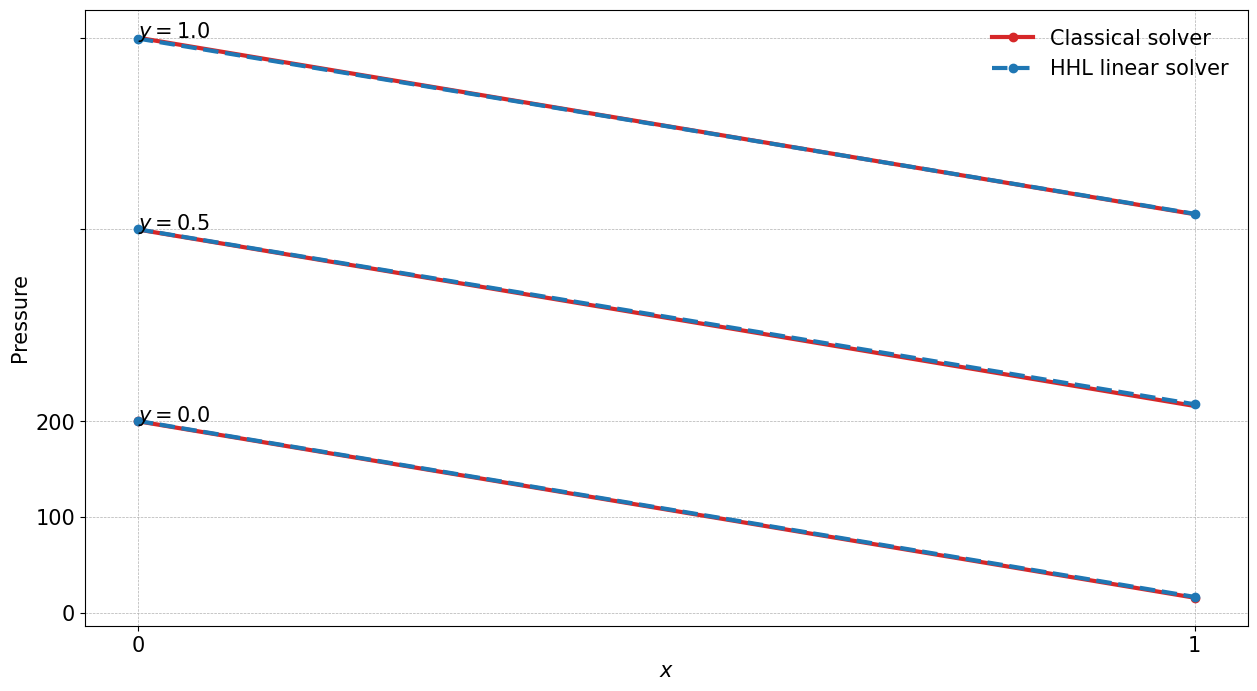

In [12]:
if var=='pressure':
    # compute factor between analytical solution and normalized linear solvers
    factor = P_analytic[0,0]/state_true_norm.reshape(ny, nx)[0,0]
    offset = P_analytic[0,0] - (state_true_norm.reshape(ny, nx) * factor)[0,0]
    state_true_norm_ref = (state_true_norm.reshape(ny, nx) * factor) + offset
    state_hhl_ref = (state_hhl.reshape(ny, nx) * factor) + offset
    print(f'Fidelity w.r.t analytical: {fidelity(P_analytic.reshape(-1), state_hhl_ref.reshape(-1))}')
    print(f'Fidelity w.r.t classical: {fidelity(state_true_norm_ref.reshape(-1), state_hhl_ref.reshape(-1))}')

    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(1,1,figsize=(15, 8), facecolor="1")
    
    # Pressure
    prop_plt = 1.0*state_true_norm_ref
    prop_plt_sim = 1.0*state_hhl_ref
    # first line (for legend)
    i = 0
    offset = i*np.max(prop_plt)
    prop = P_analytic[i,:] + offset
    ax.text(x[0], prop[0], f'$y = {y[i]:0.1f}$')
    prop = prop_plt[i,:] + offset
    ax.plot(x, prop, '-o', color='tab:red', linewidth=3, label='Classical solver')
    prop = prop_plt_sim[i,:] + offset
    ax.plot(x, prop, '--o', color='tab:blue', linewidth=3, label='HHL linear solver')
    # all other lines
    for i in range(1, ny):
        offset = i*np.max(prop_plt)
        prop = P_analytic[i,:] + offset
        ax.text(x[0], prop[0], f'$y = {y[i]:0.1f}$')
        prop = prop_plt[i,:] + offset
        ax.plot(x, prop, '-', color='tab:red', linewidth=3)
        prop = prop_plt_sim[i,:] + offset
        ax.plot(x, prop, '--o', color='tab:blue', linewidth=3)
        
    ax.grid(linestyle = '--', linewidth = 0.5)
    ax.set_yticks([0, 100, 200, 400, 600])
    ax.set_yticklabels(['0', '100', '200', '', ''])
    ax.set_ylabel('Pressure')
    ax.set_xticks(x)
    ax.set_xlabel(r'$x$')
    ax.legend(frameon=False);
    
    if saveFig: plt.savefig(figfilename, bbox_inches='tight', dpi=200)

In [13]:
if var=='velocity':
    # compute factor between analytical solution and normalized linear solvers
    factor = U_analytic[int(ny/2),0]/state_true_norm.reshape(ny, nx)[int(ny/2),0]
    offset = U_analytic[int(ny/2),0] - (state_true_norm.reshape(ny, nx) * factor)[int(ny/2),0]
    state_true_norm_ref = (state_true_norm.reshape(ny, nx) * factor) + offset
    state_hhl_ref = (state_hhl.reshape(ny, nx) * factor) + offset

    
    print(f'Fidelity w.r.t analytical: {fidelity(U_analytic.reshape(-1), state_hhl_ref.reshape(-1))}')
    print(f'Fidelity w.r.t classical: {fidelity(state_true_norm_ref.reshape(-1), state_hhl_ref.reshape(-1))}')
    
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(1,1,figsize=(10, 5), facecolor="1")
    
    # Velocity
    prop_plt = state_true_norm_ref.reshape(ny, nx) / np.max(state_true_norm_ref[:])
    prop_plt_sim = state_hhl_ref.reshape(ny, nx) / np.max(state_hhl_ref[:])
    # first line (for legend)
    i = 0
    offset = i*1
    prop = U_analytic[:,i]/Umax + offset
    ax.text(prop[0]+0.1, y[0], f'x = {x[i]:0.1f}')
    
    prop = prop_plt[:,i] + offset
    ax.plot(prop, y, '-o', color='tab:red', linewidth=3, label='Classical solver')
    
    prop = prop_plt_sim[:,i] + offset
    ax.plot(prop, y, '--o', color='tab:blue', linewidth=3, label='HHL linear solver')
    # all other lines
    for i in range(1, nx):
        offset = i*1
        prop = U_analytic[:,i]/Umax + offset
        ax.text(prop[0]+0.1, y[0], f'x = {x[i]:0.1f}')
        prop = prop_plt[:,i] + offset
        ax.plot(prop, y, '-o', color='tab:red', linewidth=3)
        prop = prop_plt_sim[:,i] + offset
        ax.plot(prop, y, '--o', color='tab:blue', linewidth=3)
        
    ax.grid(linestyle = '--', linewidth = 0.5)
    ax.set_xticks([0, 0.5, 1, 2, 3, 4])
    ax.set_xticklabels(['0', '0.5', '1', '', '', ''])
    ax.set_ylabel('y')
    ax.set_yticks(y)
    ax.set_xlabel(r'$U/U_{\mathrm{max}}$')
    ax.legend(frameon=False);
    
    if saveFig: plt.savefig(figfilename, bbox_inches='tight', dpi=200)